# 日向撮をネットワーク分析してみる

## 設定

In [36]:
import itertools
from itertools import combinations

import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itables import show

## データ読み込み

In [4]:
df_raw = (pd
          .read_csv("./Data/hinasatu_data.csv")
          .drop("id", axis=1))

df_raw.head()

,ushio,kageyama,katou,saitou,sasaki_kumi,sasaki_mirei,takase,takamoto,higashimura,kanemura,...,tomita,nibu,hamagishi,matuda,miyata,watanabe,kamimura,takahashi,morimoto,yamaguchi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
df_taker = df_raw.copy()
df_taker.loc[:,:] = np.where(df_taker==1, 1, 0)

df_taker.sum().sort_values(ascending=False)

ushio           71.0
sasaki_kumi     57.0
nibu            51.0
matuda          44.0
higashimura     35.0
kanemura        33.0
kageyama        32.0
sasaki_mirei    30.0
tomita          29.0
takase          27.0
saitou          27.0
kamimura        25.0
katou           24.0
miyata          22.0
kawata          21.0
watanabe        19.0
takahashi       18.0
takamoto        17.0
kosaka          16.0
yamaguchi       13.0
hamagishi       12.0
morimoto         9.0
dtype: float64

## グラフ定義

- 同じ画像に写っている人が多ければ多いほど、その画像から生成される重みは小さいものになるようにする
    - 2人で写ってる or ピン写がが一番大事

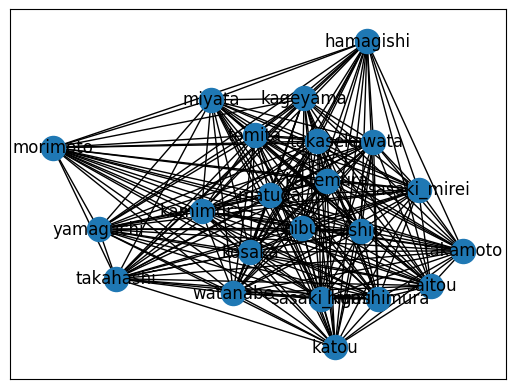

In [7]:
w_tmp = np.where(df_raw>0, 1, 0)

# 画像に写ってる人が多ければ重みが小さくなるようにする
w_tmp = w_tmp / w_tmp.sum(axis=1).reshape(632,1)
W = np.dot(w_tmp.T, w_tmp)
member_lst = df_raw.columns.tolist()

# 重み行列
df_W = pd.DataFrame(W, columns=member_lst, index=member_lst)

# グラフを生成
G = nx.Graph()
for a, b in itertools.combinations(member_lst, 2):
    G.add_edge(a, b, weight=df_W.loc[a,b])

# 描画
weights = nx.get_edge_attributes(G, 'weight')
pos = nx.spring_layout(G, seed=7)
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
# nx.draw_networkx_edge_labels(G,pos,edge_labels=weights)

# 出力
nx.write_gml(G, "hinasatsu.gml")

In [56]:
member_dict = {
    'ushio' : 1,
    'kageyama' : 1,
    'katou' : 1,
    'saitou' : 1,
    'sasaki_kumi' : 1,
    'sasaki_mirei' : 1,
    'takase' : 1,
    'takamoto' : 1,
    'higashimura' : 1,
    'kanemura' : 2,
    'kawata' : 2,
    'kosaka' : 2,
    'tomita' : 2,
    'nibu' : 2,
    'hamagishi' : 2,
    'matuda' : 2,
    'miyata' : 2,
    'watanabe' : 2,
    'kamimura' : 3,
    'takahashi' : 3,
    'morimoto' : 3,
    'yamaguchi' : 3
}

nx.set_node_attributes(G, member_dict, "generation")
nx.write_gml(G, "hinasatsu_generation.gml")

## 出現数

関わった写真の数(撮影者 or 被写体)

- にぶちゃん強い。
- 3期生/影山/宮田といった休業中のメンバーは下位に出てくる。

In [10]:
# 出現
show(df_raw.sum())

## 特徴量

- 完全グラフなので、基本的な特徴量はゼロになる。
- なので、重みつきのオプションをつけて対応する。

### 次数中心性

- 

In [25]:
# degree_dict = dict(G.degree())
# pd.DataFrame(degree_dict.values(), index=degree_dict.keys())

In [24]:
d_w = dict(G.degree(weight="weight"))
show(pd.DataFrame(d_w.values(), index=d_w.keys()))

### 固有ベクトル中心性

In [28]:
ec_dict = dict(nx.eigenvector_centrality(G, weight="weight"))
show(pd.DataFrame(ec_dict.values(), index=ec_dict.keys()))

In [72]:
degree_cent = dict(G.degree(weight="weight"))
show(pd.DataFrame(degree_cent.values(), index=degree_cent.keys()))

## コミュニティ抽出

In [62]:
lst_lc = louvain_communities(G, weight="weight", resolution=1.5)

lst_lc

[{'higashimura', 'katou', 'sasaki_kumi'},
 {'saitou', 'sasaki_mirei', 'takamoto', 'takase'},
 {'kageyama', 'ushio'},
 {'kanemura', 'kosaka', 'miyata', 'nibu'},
 {'hamagishi', 'kawata'},
 {'matuda', 'tomita', 'watanabe'},
 {'kamimura', 'morimoto', 'takahashi', 'yamaguchi'}]

In [51]:
# コミュニティを追加
for c, v_c in enumerate(lst_lc):
    for v in v_c:
        G.nodes[v]['community'] = c + 1
        
G.nodes["ushio"]

{'community': 4}

In [52]:
# 出力
nx.write_gml(G, "hinasatsu_add_community.gml")

## クラスタ係数

In [34]:
clst_coef = dict(nx.clustering(G, weight="weight"))

show(pd.DataFrame(clst_coef.values(), index=clst_coef.keys()))

## 仲のいい組み合わせ

In [37]:
def generate_ranking(graph, combination_size):
    """
    指定されたサイズの組み合わせでグラフ内のノードのランキングを生成します。

    :param graph: NetworkXグラフオブジェクト。重み付きエッジを含む必要があります。
    :param combination_size: 組み合わせに含めるノードの数。
    :return: 組み合わせとその重みの合計のリスト。重みの合計で降順にソートされます。
    """
    # 組み合わせの全リストを生成
    combinations_list = combinations(graph.nodes(), combination_size)

    # 各組み合わせの重みの合計を計算
    combinations_weights = {}
    for combination in combinations_list:
        total_weight = sum(graph[u][v]['weight'] for u, v in combinations(combination, 2))
        combinations_weights[combination] = total_weight

    # 重みの合計で降順にソートしてランキングを作成
    ranked_combinations = sorted(combinations_weights.items(), key=lambda x: x[1], reverse=True)

    return ranked_combinations

# 関数を使用してランキングを生成（例えば、4人の組み合わせ）
combination_size = 2
ranking = generate_ranking(G, combination_size)

# ランキングの表示
print(f"中の良い{combination_size}人組のランキング:")
for rank, (combination, weight) in enumerate(ranking, 1):
    print(f"{rank}: 人物{combination}、合計重み: {weight}")

中の良い2人組のランキング:
1: 人物('katou', 'sasaki_kumi')、合計重み: 3.870136210713966
2: 人物('sasaki_kumi', 'higashimura')、合計重み: 3.1742008365643066
3: 人物('kanemura', 'nibu')、合計重み: 3.0143268128807588
4: 人物('kosaka', 'nibu')、合計重み: 2.9999459342965835
5: 人物('saitou', 'higashimura')、合計重み: 2.974903784410112
6: 人物('kanemura', 'kosaka')、合計重み: 2.810779267629917
7: 人物('saitou', 'takamoto')、合計重み: 2.735459339965667
8: 人物('katou', 'higashimura')、合計重み: 2.677959339965667
9: 人物('saitou', 'sasaki_kumi')、合計重み: 2.6710148955212225
10: 人物('ushio', 'nibu')、合計重み: 2.652723712074361
11: 人物('kamimura', 'takahashi')、合計重み: 2.2156772268135905
12: 人物('sasaki_mirei', 'takase')、合計重み: 2.176116936337549
13: 人物('saitou', 'sasaki_mirei')、合計重み: 2.0586622878114715
14: 人物('kanemura', 'kamimura')、合計重み: 1.9807792676299167
15: 人物('sasaki_kumi', 'tomita')、合計重み: 1.9666794205905096
16: 人物('ushio', 'takase')、合計重み: 1.9467360577533737
17: 人物('ushio', 'higashimura')、合計重み: 1.9363562391592697
18: 人物('kawata', 'matuda')、合計重み: 1.929751982948786
19: 人物('us

In [38]:
# 関数を使用してランキングを生成（例えば、4人の組み合わせ）
combination_size = 3
ranking = generate_ranking(G, combination_size)

# ランキングの表示
print(f"中の良い{combination_size}人組のランキング:")
for rank, (combination, weight) in enumerate(ranking, 1):
    print(f"{rank}: 人物{combination}、合計重み: {weight}")

中の良い3人組のランキング:
1: 人物('katou', 'sasaki_kumi', 'higashimura')、合計重み: 9.72229638724394
2: 人物('kanemura', 'kosaka', 'nibu')、合計重み: 8.825052014807259
3: 人物('saitou', 'sasaki_kumi', 'higashimura')、合計重み: 8.820119516495641
4: 人物('katou', 'saitou', 'sasaki_kumi')、合計重み: 7.8041104462008555
5: 人物('saitou', 'takamoto', 'higashimura')、合計重み: 7.294286183162306
6: 人物('ushio', 'katou', 'sasaki_kumi')、合計重み: 7.209163881776269
7: 人物('ushio', 'kosaka', 'nibu')、合計重み: 7.0623378028897505
8: 人物('ushio', 'kanemura', 'nibu')、合計重み: 6.97255201480726
9: 人物('katou', 'saitou', 'higashimura')、合計重み: 6.915822464341446
10: 人物('ushio', 'sasaki_kumi', 'higashimura')、合計重み: 6.846737577921394
11: 人物('saitou', 'sasaki_kumi', 'takamoto')、合計重み: 6.8145186094661625
12: 人物('ushio', 'saitou', 'higashimura')、合計重み: 6.707060707173095
13: 人物('saitou', 'sasaki_mirei', 'takamoto')、合計重み: 6.70216600175641
14: 人物('kanemura', 'nibu', 'matuda')、合計重み: 6.680350053154749
15: 人物('kanemura', 'nibu', 'kamimura')、合計重み: 6.456293511405899
16: 人物('katou', 

In [39]:
# 関数を使用してランキングを生成（例えば、4人の組み合わせ）
combination_size = 4
ranking = generate_ranking(G, combination_size)

# ランキングの表示
print(f"中の良い{combination_size}人組のランキング:")
for rank, (combination, weight) in enumerate(ranking, 1):
    print(f"{rank}: 人物{combination}、合計重み: {weight}")

中の良い4人組のランキング:
1: 人物('katou', 'saitou', 'sasaki_kumi', 'higashimura')、合計重み: 16.63117440714094
2: 人物('ushio', 'katou', 'sasaki_kumi', 'higashimura')、合計重み: 14.997680297465513
3: 人物('saitou', 'sasaki_kumi', 'takamoto', 'higashimura')、合計重み: 14.547546289227109
4: 人物('ushio', 'saitou', 'sasaki_kumi', 'higashimura')、合計重み: 14.288456941456444
5: 人物('ushio', 'kanemura', 'kosaka', 'nibu')、合計重み: 14.192945373252565
6: 人物('kanemura', 'kosaka', 'nibu', 'matuda')、合計重み: 13.774076744933389
7: 人物('kanemura', 'kosaka', 'nibu', 'kamimura')、合計重み: 13.577797980962314
8: 人物('katou', 'sasaki_kumi', 'takamoto', 'higashimura')、合計重み: 13.431622252945928
9: 人物('kanemura', 'kosaka', 'nibu', 'watanabe')、合計重み: 13.303880747402225
10: 人物('kanemura', 'kosaka', 'tomita', 'nibu')、合計重み: 12.964632300488944
11: 人物('ushio', 'katou', 'saitou', 'sasaki_kumi')、合計重み: 12.938938800866874
12: 人物('saitou', 'sasaki_kumi', 'sasaki_mirei', 'higashimura')、合計重み: 12.841452184918719
13: 人物('kanemura', 'kosaka', 'nibu', 'miyata')、合計重み: 12.8211